In [35]:
import pandas as pd
import pystan
import pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# データを整理
Github公開時にはここは削除

# ベイズのmodelingを行う

<img src="https://latex.codecogs.com/gif.latex?Y'[n]&space;\sim&space;Normal(\alpha&space;[PID[n]]&space;&plus;&space;\beta&space;X'[n],&space;\sigma_{Y}&space;)&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;n&space;=&space;1,\ldots,&space;N\\&space;\alpha[k]&space;=&space;\alpha_{all}&space;&plus;&space;\alpha_{id}[k]&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,k&space;=&space;1,\ldots,&space;K\\&space;\alpha_{id}[k]&space;\sim&space;Normal(0,&space;\sigma_{\alpha})&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,&space;\,k&space;=&space;1,\ldots,&space;K\\">

In [4]:
model = """
    data {
        int N;
        int K;
        real X[N];
        real Y[N];
        int<lower=1, upper=K> PID[N];
    }
    parameters {
        real a0;      // a_{all}に相当するもの
        real b;        // β
        real ak[K]; // a_{id}に相当するもの
        real<lower=0> s_a;
        real<lower=0> s_Y;
    }

    transformed parameters{
        real a[K];
        for (k in 1:K){
            a[k] = a0 + ak[k];    // a[k]に相当するもの
        }
    }

    model {
        for (k in 1:K){
            ak[k] ~ normal(0, s_a);
        }

        for (n in 1:N){
            Y[n] ~ normal(a[PID[n]] + b*X[n], s_Y);
        }
    }
"""

In [5]:
%time stm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_209bcf42bcd79815e146ef5ad19b1f72 NOW.


CPU times: user 1.31 s, sys: 90.9 ms, total: 1.4 s
Wall time: 47.5 s


In [18]:
# compileに時間がかかるためsaveしておく
with open('model.pkl', 'wb') as f:
    pickle.dump(stm, f)

# 実際にデータを投入
データを整理のfactorでID(列名: ID), 予測値(列名: Y)、実測値(列名: X)が並んでいるdfを作成している<br>
ただし、IDは1から始まる連番に変更する

In [14]:
N = len(df)
K = len(list(set(list(df["ID"]))))
X = df["X"]
Y = df["Y"]
PID = df["ID"].astype("int")
input_data = {'N': N, 'K': K, "X": X, "Y": Y, "PID": PID}

In [19]:
stm = pickle.load(open('model.pkl', 'rb'))
fit = stm.sampling(
    data = input_data,
    iter = 2000,
    chains = 4,
    thin = 1,
    seed = 1234,
)

In [21]:
print(fit)

Inference for Stan model: anon_model_209bcf42bcd79815e146ef5ad19b1f72.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%     25%    50%     75%   97.5%  n_eff   Rhat
a0      4.8e-4  8.7e-4   0.05  -0.11   -0.03 6.7e-4    0.04     0.1   3730    1.0
b         0.83  8.5e-4   0.05   0.73     0.8   0.83    0.87    0.93   3812    1.0
ak[1]    -0.31  3.0e-3   0.24  -0.78   -0.47   -0.3   -0.15    0.14   6450    1.0
ak[2]      0.1  2.7e-3   0.23  -0.34   -0.05    0.1    0.25    0.56   7252    1.0
ak[3]    -0.15  2.9e-3   0.24  -0.63    -0.3  -0.15    0.01    0.32   7038    1.0
ak[4]     0.09  2.8e-3   0.23  -0.36   -0.08   0.09    0.24    0.55   6788    1.0
ak[5]    -0.18  2.9e-3   0.23  -0.63   -0.34  -0.17   -0.02    0.26   6313    1.0
ak[6]    -0.05  2.7e-3   0.23   -0.5   -0.21  -0.06     0.1    0.39   6904    1.0
ak[7]     0.05  2.9e-3   0.24  -0.41   -0.12   0.05    0.21    0.52   666

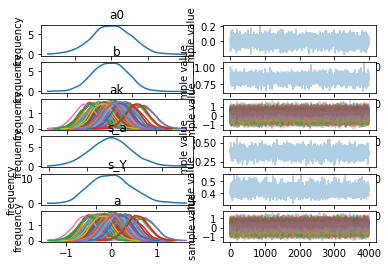

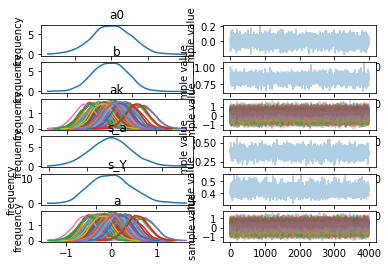

In [27]:
fit.plot()

# 95%信頼区間を求める

In [33]:
la  = fit.extract(permuted=True) # permutedをTrueにすることで項目ごとに取り出せる
print(la["b"].shape)
la["b"]

(4000,)


array([0.74851123, 0.8447336 , 0.85198105, ..., 0.8836202 , 0.82651826,
       0.76890464])

In [40]:
bs = la["b"]
print(round(np.percentile(bs, 50), 3), "    95%CI: ", 
      round(np.percentile(bs, 2.5), 3), "-", round(np.percentile(bs, 97.5), 3))

0.833     95%CI:  0.73 - 0.933
